## Setup

In [3]:
import json
import os
import random

import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# from sklearn.metrics import confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Load the data

We will use the SMD data sets for training and testing.

You can find raw data in https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset

I preprocessed this dataset which consist of 28 entities and 38 dimensions


In [4]:
train_url = "./datasets/SMD/train/"
test_url = "./datasets/SMD/test/"
machine_label = {1: 8, 2: 9, 3: 11}
train_data = []
test_data = []
for i, nums in machine_label.items():
    train = []
    test = []
    for j in range(1, nums + 1):
        file_name = f"machine-{i}-{j}.csv"
        df_train = pd.read_csv(
            os.path.join(train_url, file_name), parse_dates=True, index_col="timestamp"
        )
        df_test = pd.read_csv(
            os.path.join(test_url, file_name), parse_dates=True, index_col="timestamp"
        )
        train.append(df_train)
        test.append(df_test)
    train_data.append(train)
    test_data.append(test)

## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

/home/chlehdwon/anaconda3/envs/cs495_winter/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


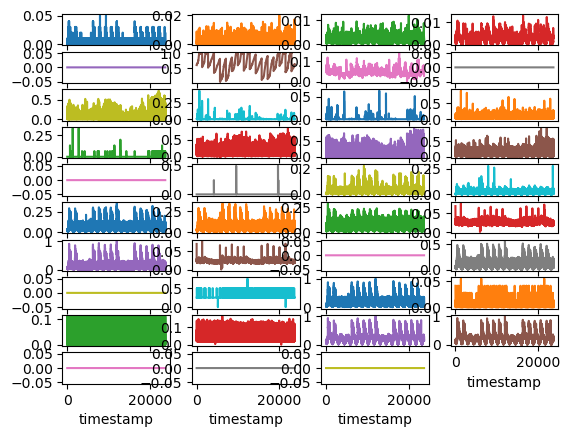

In [25]:
fig, ax = plt.subplots()
train_data[machine][idx].plot(legend=False, ax=ax, subplots=True, layout=(10, 4), sharex=True)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

## Prepare training data


In [29]:
# Normalize and save the mean and std we get,
# for normalizing test data.
# Since model is too simple, so we will use only few featrues for learning.
num_of_features = 38
data_for_train = train_data[machine][idx].fillna(method='ffill').iloc[:, :num_of_features]

# training_mean = data_for_train.mean()
# training_std = data_for_train.std()
training_mean = 0
training_std = 1
df_training_value = (data_for_train - training_mean) / training_std

           feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
timestamp                                                                     
0                0.0   0.000510   0.001152   0.002355        0.0   0.609359   
1                0.0   0.000595   0.001152   0.002355        0.0   0.610183   
2                0.0   0.001445   0.001152   0.002355        0.0   0.611626   
3                0.0   0.001020   0.001152   0.002355        0.0   0.612451   
4                0.0   0.000340   0.000864   0.002018        0.0   0.613069   

           feature_7  feature_8  feature_9  feature_10  ...  feature_29  \
timestamp                                               ...               
0           0.046951        0.0   0.043478    0.003788  ...         0.0   
1           0.048030        0.0   0.326087    0.000000  ...         0.0   
2           0.049649        0.0   0.000000    0.000000  ...         0.0   
3           0.051268        0.0   0.000000    0.000000  ...         0.0

In [55]:
data_for_train.mean()
data_for_train.std()
norm = (data_for_train - data_for_train.mean()) / data_for_train.std()
norm.mean()

feature_1     0.007165
feature_2     0.001224
feature_3     0.001124
feature_4     0.002116
feature_5     0.000000
feature_6     0.252388
feature_7     0.014519
feature_8     0.000000
feature_9     0.072673
feature_10    0.005872
feature_11    0.011379
feature_12    0.042178
feature_13    0.005100
feature_14    0.110596
feature_15    0.111815
feature_16    0.119346
feature_17    0.000000
feature_18    0.005386
feature_19    0.029972
feature_20    0.018340
feature_21    0.058861
feature_22    0.055835
feature_23    0.033748
feature_24    0.003579
feature_25    0.152407
feature_26    0.002876
feature_27    0.000000
feature_28    0.094391
feature_29    0.000000
feature_30    0.038574
feature_31    0.160540
feature_32    0.008499
feature_33    0.020043
feature_34    0.016403
feature_35    0.184947
feature_36    0.184959
feature_37    0.000000
feature_38    0.000000
dtype: float64

### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [30]:
# Increase TIME_STEPS: high recall, low precision
# Decrease TIME_STEPS: low recall, high precision
TIME_STEPS = 500


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (23201, 500, 38)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [31]:
model = keras.Sequential(
    [
        layers.InputLayer((x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=x_train.shape[2], kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 250, 32)           8544      
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 125, 16)           3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 250, 16)           1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 500, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 500, 38)          

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [32]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Epoch 1/50
164/164 [==============================] - 4s 21ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 2/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
164/164 [==============================] - 3s 16ms/step - loss: 9.3464e-04 - val_loss: 7.6066e-04
Epoch 5/50
164/164 [==============================] - 3s 16ms/step - loss: 8.2228e-04 - val_loss: 6.1467e-04
Epoch 6/50
164/164 [==============================] - 2s 15ms/step - loss: 7.4828e-04 - val_loss: 5.7890e-04
Epoch 7/50
164/164 [==============================] - 3s 16ms/step - loss: 6.9639e-04 - val_loss: 5.3407e-04
Epoch 8/50
164/164 [==============================] - 3s 16ms/step - loss: 6.5615e-04 - val_loss: 5.0466e-04
Epoch 9/50
164/164 [==============================] - 2s 15ms/step - loss: 6.2210e-04 - val_loss: 4.8496e-04
Epoch 10/50
164/164 [======================

Let's plot training and validation loss to see how the training went.

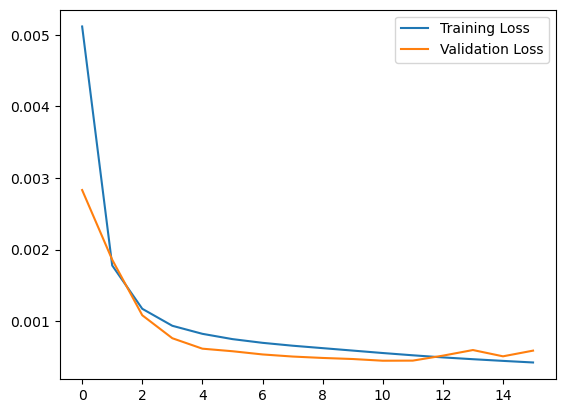

In [57]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

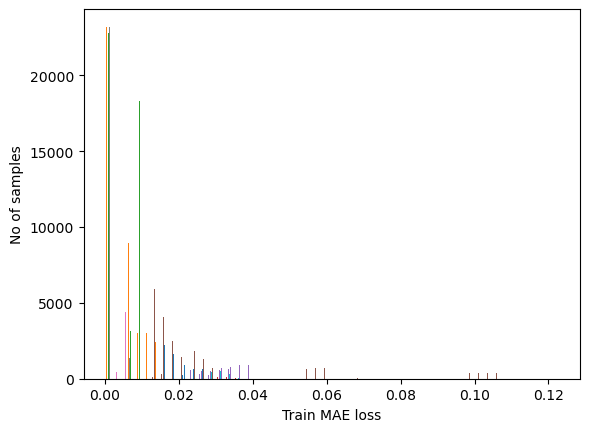

Reconstruction error threshold:  [0.00472735 0.00096123 0.00084472 0.00171861 0.00044383 0.1225824
 0.02432338 0.00125137 0.01923069 0.00275771 0.00352333 0.03221577
 0.00336701 0.03626099 0.04284373 0.0398496  0.0004637  0.00247559
 0.02288185 0.00805811 0.03124194 0.02137416 0.01498458 0.00543242
 0.06763363 0.0029272  0.00075433 0.03533031 0.0006045  0.0354037
 0.06368269 0.00586193 0.01106956 0.00989755 0.06997445 0.06814186
 0.00080555 0.00067297]


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss, axis=0)
print("Reconstruction error threshold: ", threshold)

### Prepare test data

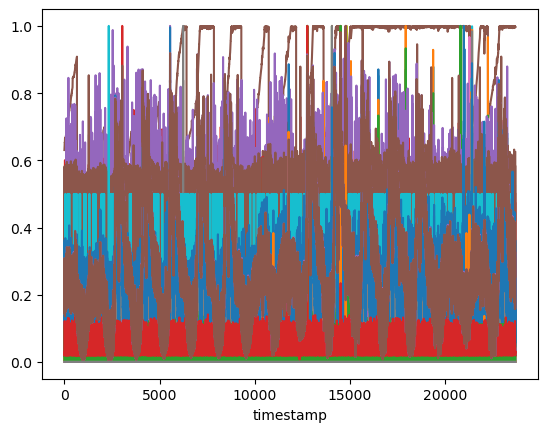

Test input shape:  (23201, 500, 38)


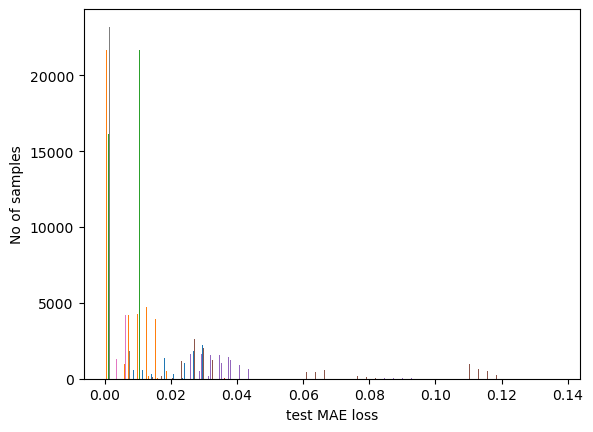

(23201, 38)
Number of anomaly samples:  15
Indices of anomaly samples:  (array([12715, 12719, 12721, 12723, 12725, 12727, 12729, 12731, 12733,
       12735, 12737, 12739, 12743, 14055, 14057]),)


In [36]:
data_for_test = test_data[machine][idx]

df_test_value = (data_for_test - training_mean) / training_std

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
# test_mae_loss = test_mae_loss.reshape((-1))

# Detect all the samples which are anomalies.
print(test_mae_loss.shape)
anomalies = np.sum(test_mae_loss, axis=1) > np.sum(threshold)
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [39]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.any(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

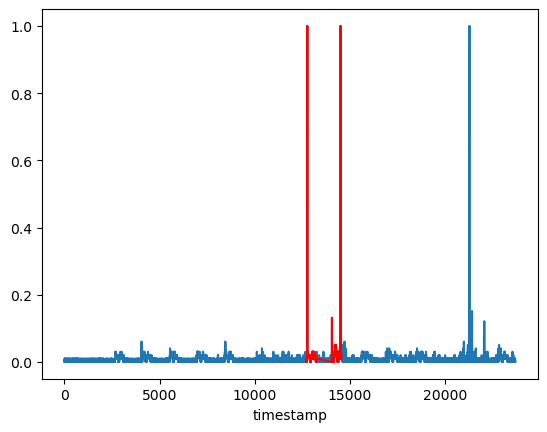

In [40]:
df_subset = test_data[machine][idx]["feature_1"].iloc[anomalous_data_indices]
fig, ax = plt.subplots()
test_data[machine][idx]["feature_1"].plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

## Evaluate Results

We will calculate accuracy, recall and precision to evalutate our results

In [41]:
test_pred = np.zeros(len(test_data[machine][idx]))
test_label = test_data[machine][idx]["label"]
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label) * 100
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred) * 100
recall = (np.sum(test_pred * test_label)) / np.sum(test_label) * 100

print(f"accuracy: {accuracy:.2f}%")
print(f"precision: {precision:.2f}%")
print(f"recall: {recall:.2f}%")

accuracy: 83.89%
precision: 2.04%
recall: 0.74%


In [42]:
from sklearn.metrics import classification_report
print(classification_report(test_label, test_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     20867
           1       0.02      0.01      0.01      2833

    accuracy                           0.84     23700
   macro avg       0.45      0.48      0.46     23700
weighted avg       0.77      0.84      0.80     23700

